## 分析A/B测试结果

我们设计项目的初衷是希望让它涵盖统计课程里所有的内容，所以项目会有难度。如果你进行不顺利，不用着急，你可以回顾以前课程中的内容，或者寻求帮助。如果你成功完成项目，代表你已掌握这部分内容。祝你好运！

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)
- [总结](#conclusions)


<a id='intro'></a>
### 简介

A/B 测试是数据分析师和数据科学家需要经常完成的工作，非常重要。如果你在工作中有一些实践经验，那学习起来就会更加游刃有余。

本项目设定了一家电子商务网站运行 A/B 测试的情境。你的目标是通过这个项目来帮助公司分析和决定他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

**注意，有些题目会提醒你先做课堂页面的测试问题，这些测试会提供答案，可以给你提供一些帮助。** 最后做完项目时记得检查，确保提交内容符合[审阅标准](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric) 。

<a id='probability'></a>
#### I - 概率

先导入数据。

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  你可以直接进行以下问题的回答，或者 **做教室里的测试 1** 。

a. 导入数据集，查看前几行数据：

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 查看数据集的行数。

In [3]:
df.shape

(294478, 5)

c. 查看数据集中的用户数量（不同的user_id数）。

In [4]:
df.user_id.nunique()

290584

d. 转化用户的占比。

In [5]:
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

e. 请计算数据中 `new_page` 与 `treatment` 不匹配的次数。提示：在一个合理的实验设计里，控制组(control) 应该对应旧页面(old_page)，实验组(treatment) 对应新页面(new_page)。

In [6]:
((df[df['group'] == 'control'].landing_page == 'new_page').sum() + 
(df[df['group'] == 'treatment'].landing_page == 'old_page').sum())

3893


f. 是否有任何行空缺数值？

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 和 **new_page** 不匹配的行或 **control** 与 **old_page** 不匹配的行，我们不能确定该行是否接收到了新页面还是旧页面。如何处理这些行？你可以返回教室里的页面先做 **测试 2** 。  

a. 现在，参照测试2的答案去创建一个符合要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [8]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))]
df2 = df2.copy()

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 根据 **df2** 来回答以下问题，或者做教室里的 **测试3** 。

a.  **df2** 中的用户数量（不同的 **user_id**) ?

In [10]:
df2.user_id.nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？

In [11]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. 这个重复  **user_id** 的行信息是什么？

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除一行重复行，但仍然存储 dataframe 为 **df2**。

In [13]:
df2.drop([2893], inplace = True)

`4.` 使用优化过的 **df2** 来回答以下问题，或者做 **测试 4**。

a. 用户成功转化的整体概率是多少？（不分旧页面或者新页面）

In [14]:
(df2.converted == 1).sum() / len(df2)

0.11959708724499628

b. `control` 组用户的转化率是多少？

In [15]:
p_control = (df2.query('group == "control"').converted == 1).sum() / (df2.group == 'control').sum()
p_control

0.1203863045004612

c. `treatment` 组用户的转化率是多少？

In [16]:
p_treatment = (df2.query('group == "treatment"').converted == 1).sum() / (df2.group == 'treatment').sum()
p_treatment

0.11880806551510564

d. 一个用户收到新页面的概率是多少？

In [17]:
(df2.landing_page == 'new_page').sum() / len(df2)

0.5000619442226688

In [18]:
# Treatment组和Control组的转化率差
sample_diff = p_treatment - p_control

e. 分析到这里，你是否认为有足够的数据支持来证明旧页面或者新页面可以带来更高的转化率？

**在这里写出你的答案。**

这组数据不能支持，理由如下
数据比例并没有明显的差距, 我们在不通过假设检验之前无法确定这个差异是否具有统计显著性


<a id='ab_test'></a>
### II - A/B 测试

因为每个事件都对应有一个时间记录（time stamp 时间戳），所以技术上你可以实现每次观察都连续运行假设检验。

然而，问题的难点在于，什么时候停止你的试验：是在发现其中一组的试验效果足够好时立即停止？还是在这样的观察结果又持续发生了一段时间再停止？需要运行多长时间才能确认两个页面没有带来用户转化率的显著差异？

这些问题是 A/B 测试中最难的部分。如果你对下面提到的一些知识点比较生疏，请先回顾课程中的“描述统计学”部分的内容。

`1.` 现在，你需要根据我们提供的数据做出决策：你假设旧页面效果更佳，除非在一类错误在5%以内，新页面被证明更好。基于此，你的零假设和备择假设是什么？ 你可以用文字表述或用 **$p_{old}$** 与 **$p_{new}$** （即，旧页面转化率与新页面转化率）来陈述你的假设。

**在这里给出你的答案。**

$H_0: p_{new} - p_{old} <= 0$

$H_1: p_{new} - p_{old} > 0 $

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ 与 $p_{old}$ 都有相同的转化成功的概率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，我们还假设它们都等于**ab_data.csv** 中的 **转化率(converted)**。  <br>

现在，在新旧页面上执行抽样分布，并计算 **转化(converted)** 差异。记住，每个页面的样本大小要与 **ab_data.csv** 相同。计算零假设中10000次迭代计算的估计值。  <br>

使用下面的单元格提供这个模拟试验的内容。如果不太理解如何进行模拟，不要担心，你可以通过回答下面的问题来理清思路。同时，你可以在教室里的 **测试 5** 里验证你的答案是否正确。<br>

a. 在零假设中，$p_{new}$ **转化率** 是多少？

In [19]:
p_new = (df2.converted == 1).sum() / len(df2)
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$ **转化率** 是多少？ 

In [20]:
p_old = (df2.converted == 1).sum() / len(df2)
p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

In [21]:
n_new = (df2.landing_page == 'new_page').sum()
n_new

145310

d.  $n_{old}$?是多少？

In [22]:
n_old = (df2.landing_page == 'old_page').sum()
n_old

145274

e. 在零假设中，使用 $p_{new}$ （新页面的转化率）模拟 $n_{new}$ 个新页面的转化，并将这些 $n_{new}$ 个 1 和 0 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [23]:
import numpy as np
new_page_converted = np.random.choice(2, n_new, replace=True, p=[1-p_new, p_new])

f. 在零假设中，使用 $p_{old}$ （旧页面的转化率）模拟 $n_{old}$ 个旧页面的转化，并将这些  $n_{old}$ 个 1 和 0 存储在 **old_page_converted** 中。

In [24]:
old_page_converted = np.random.choice(2, n_old, replace=True, p=[1-p_old, p_old])

g. 根据 e 和 f，计算 $p_{new}$ 和 $p_{old}$ 的差异值（$p_{new}$ - $p_{old}$）。

In [25]:
pnew = (new_page_converted == 1).sum() / len(new_page_converted)
pold = (old_page_converted == 1).sum() / len(old_page_converted)
diff = pnew - pold
diff

-0.002982493939603287

h. 由于单个数值不能形成分布图形，请参考以上a-g的过程，模拟 10,000 个 $p_{new}$ 与 $p_{old}$ 差异值（$p_{new}$ - $p_{old}$），将这 10,000 个值存储在 **p_diffs** 中。

In [26]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(2, n_new, replace=True, p=[1-p_new, p_new])
    old_page_converted = np.random.choice(2, n_old, replace=True, p=[1-p_old, p_old])
    pnew = (new_page_converted == 1).sum() / len(new_page_converted)
    pold = (old_page_converted == 1).sum() / len(old_page_converted)
    diff = pnew -pold
    p_diffs.append(diff)

i. 绘制一个 **p_diffs** 分布图形。图形跟你的预期相符吗？

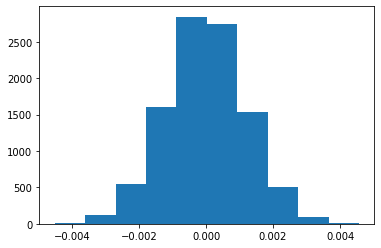

In [27]:
plt.hist(p_diffs);

图形很接近正态分布，符合预期

j.  **p_diffs**列表的数值中，有多少比例的数值会大于 **ab_data.csv** 中观察到的实际**转化率差异** ？

In [28]:
(p_diffs > sample_diff).mean()

0.9066

k. 用文字解释一下你刚才在 **j.** 中计算出来的结果。在数据研究中，这个值是什么？ 根据这个数值，请判断新旧页面的转化率是否有显著差异。

**在这里给出你的答案。**


p值的计算结果为0.9。这个含义是如果我们初始时假定新转化率小于等于旧转换率相等，那么测试数据中观测到当前的转化率的几率为90.62%,这个概率是比较高的，如果以alpha = 0.05 作为I类错误阈值，计算的p_value > 0.05，没有理由判定我们的初始假设是不正确的。

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。使用内置程序可能很容易就能取得结果，但上面的内容仍然很重要，它可以训练你具有正确的数据统计思维。填写下面的内容来计算每个页面的转化次数，以及收到每个页面的用户数。计算新旧页面出现的次数，也就是数据中 `n_old` 与 `n_new` 分别出现的行数。

In [29]:
import statsmodels.api as sm

convert_old = (df2.query('landing_page == "old_page"').converted == 1).sum()
convert_new = (df2.query('landing_page == "new_page"').converted == 1).sum()
n_old = (df2.landing_page == 'old_page').sum()
n_new = (df2.landing_page == 'new_page').sum()

m. 现在使用 `stats.proportions_ztest` 来计算你的 z-score (什么是 [z-score](https://www.khanacademy.org/math/statistics-probability/modeling-distributions-of-data/z-scores/a/z-scores-review)) 与 p-value。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 的资料可以提供额外信息。

In [30]:
import statsmodels.stats.proportion as sm
z_score, p_value = sm.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. 根据上题算出的 z-score 和 p-value，你认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 问题中的结果一致吗？

**在这里给出你的答案。**

使用`stats.proportions_ztest`函数计算的p值为0.9050， 如果以alpha = 0.05 作为I类错误阈值，计算的p_value > 0.05, 没有足够的证据证明新页面的转化率高于旧页面的转化率。这里我们认为，新旧页面的转化率没有区别。 
这个结果和**j.**与**k.**问题中的结果是一致的。

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

**在这里给出你的答案。**

逻辑回归

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [31]:
import statsmodels.api as sm
df2['ab_page'] = df2.group.map({'treatment':1,'control':0})
df2['intercept'] = 1


c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [32]:
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

In [33]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Feb 2020   Pseudo R-squ.:               8.077e-06
Time:                        23:26:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？

**在这里给出你的答案。**

与`ab_page`关联的p值为0.1899

回归模型相关的零假设和被择假设分别是

$H_0: p_{new} - p_{old} = 0$

$H_1: p_{new} - p_{old} \neq 0 $

**Part II**种的零假设和备择假设为

$H_0: p_{new} - p_{old} <= 0$

$H_1: p_{new} - p_{old} > 0 $

虽然都是以零值作为边界数值，但是比较的方向是不同的，我们来做一个简单计算


In [34]:
(1 - p_value)*2

0.18988337448195103

处理后会发现其实用回归模型的计算和**Part II**的计算结果是一致的



f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

**在这里给出你的答案。**

将其它因素（比如用户地域，登陆时间等）纳入对转化率影响的分析，可以让我们从更多的维度考察影响转化率的原因；同时，把加入这些因素添加进回归模型，它们索提供的额外信息有助于我们消除相关误差，提高预测的准确度。
但是，如果添加的因素彼此相关，就会出现多重共线性，会导致简单线性回归系数偏离我们想要的方向。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [35]:
import statsmodels.api as sm

df3=pd.read_csv('countries.csv')
df3=df2.merge(df3,on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [36]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3 = df3.drop('US',axis=1)
df3['intercept'] = 1
logit_mod = sm.Logit(df3.converted,df3[['intercept','ab_page','CA','UK']])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 15 Feb 2020   Pseudo R-squ.:               2.323e-05
Time:                        23:26:02   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

从结果来看CA的p值为0.130，UK的p值为0.457，均大于0.05的通常alpha水平，这意味着国家项对转化率的影响不具有统计学显着性，没有证据表明国家项对转化率有影响。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [37]:
df3['new_page']=df3.landing_page.map({'new_page':1,'old_page':0})
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US,0,0,0


In [38]:
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']

In [39]:
df3['intercept'] = 1
logit_mod = sm.Logit(df3.converted,df3[['intercept','ab_page','CA','new_CA',]])
result = logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 15 Feb 2020   Pseudo R-squ.:               2.567e-05
Time:                        23:26:03   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1409
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9880      0.008   -240.457      0.000      -2.004      -1.972
ab_page       -0.0123      0.012     -1.049      0.294      -0.035       0.011
CA            -0.0160      0.037     -0.429      0.668      -0.089       0.057
new_CA        -0.0552      0.053     -1.034      0.301      -0.160       0.049
==============================================================================
"""

In [40]:
df3['intercept']=1
logit_mod=sm.Logit(df3.converted,df3[['intercept','ab_page','UK','new_UK',]])
result=logit_mod.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 15 Feb 2020   Pseudo R-squ.:               2.036e-05
Time:                        23:26:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2278
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9876      0.009   -213.551      0.000      -2.006      -1.969
ab_page       -0.0236      0.013     -1.788      0.074      -0.050       0.002
UK            -0.0046      0.019     -0.247      0.805      -0.041       0.032
new_UK         0.0345      0.026      1.307      0.191      -0.017       0.086
==============================================================================
"""

`new_CA` 和 `new_UK`的p值为0.301 和0.191，均大于0.05的通常alpha水平，这意味着页面与国家项相互作用对转化率的影响也不具有统计学显着性，没有证据表明其对转化率有影响。

<a id='conclusions'></a>
## 总结

根据以上分析，我们没有发现新页面在统计意义上对提升页面转化率有影响，考虑到用户习惯和新页面可能带来的其它不稳定因素，不建议商家发布新页面。